In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchsummary
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00


In [5]:
import captum
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# these are the mean and std of the data per channel
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])


transform2 = transforms.Compose([
    transforms.ToTensor()
    ])

def denormalize(tensor):
    tensor = tensor*std + mean
    return tensor

# function for viewling image
def get_rgb_img(img):
    # arrange channels
    img = img.numpy().transpose((1,2,0))

    # use mean and std values
    img = denormalize(img)

    # clip values and view image
    rgb_img = np.clip(img,0,1)
    #plt.imshow(rgb_img)

    return np.float32(rgb_img)

## Load Model

In [8]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Function for obtaining gradcam attention map

In [85]:
def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)

    normalized_img = (img - min_val) / (max_val - min_val)
    normalized_img *= 255
    return normalized_img.astype(np.uint8)

def get_attention_map(model, x, x_fullsize, layer, alpha):

    model.to(device)
    x = x.to(device)
    model.eval()

    # convert data to tensor dimension
    input_img = x.unsqueeze(0)
    output = F.softmax(model(input_img), dim = 1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()

    # get grad cam results
    layer_gradcam = LayerGradCam(model, model.features[layer])

    # this is the heatmap for the original feature map
    attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)
    attributions_lgc = attributions_lgc.squeeze(1).cpu().permute(1,2,0).detach().numpy()
    #upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, x.shape[1:])

    # overlay heatmap over rgb image
    rgb_image = normalize_image(get_rgb_img(x_fullsize))
    heatmap_arr = normalize_image(attributions_lgc)

    # Resize heatmap if sizes are different
    if rgb_image.shape[:2] != heatmap_arr.shape[:2]:
        resized_heatmap = cv2.resize(heatmap_arr, (rgb_image.shape[:2][1],rgb_image.shape[:2][0]), interpolation=cv2.INTER_LANCZOS4)

    # Apply colormap to heatmap
    heatmap_colored = cv2.applyColorMap(np.uint8(resized_heatmap), cv2.COLORMAP_JET)

    overlaid_image = normalize_image((1-alpha)*rgb_image + alpha*heatmap_colored)

    return overlaid_image, pred_label_idx

## Load and Transform Image

In [77]:
transform = transforms.Compose([
 transforms.Resize((224, 224)),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transform2 = transforms.Compose([
 transforms.ToTensor()
])


In [87]:
def plot_gradcam_attribution_map(img_path):
    test_img = Image.open(img_path)
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
    test_img_data = np.asarray(test_img)
    full_trans_img = transform2(test_img)
    output, label = get_attention_map(vgg16, input_img, full_trans_img, 28, 0.3)
    return test_img_data, output, label

In [89]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Data/goose.jpg'
test_img_data, output, label = plot_gradcam_attribution_map(img_path)
print(label.item())

99


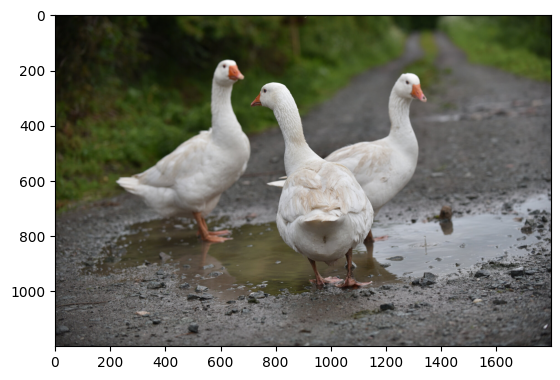

In [83]:
plt.imshow(test_img_data)

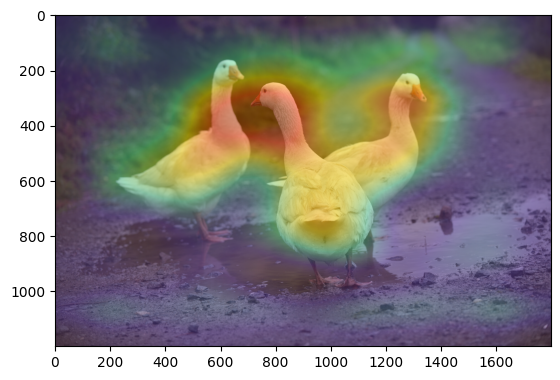

In [84]:
plt.imshow(output)

In [90]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Data/elephants.jpg'
test_img_data, output, label = plot_gradcam_attribution_map(img_path)
print(label.item())

101


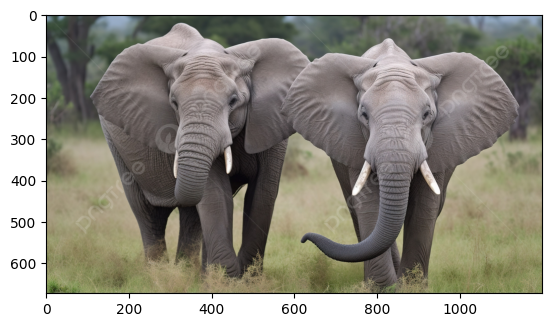

In [91]:
plt.imshow(test_img_data)

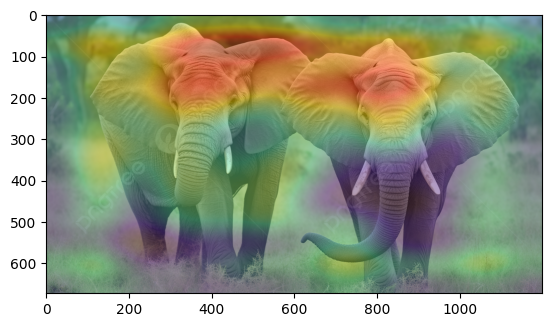

In [92]:
plt.imshow(output)

In [93]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Data/hen.jpg'
test_img_data, output, label = plot_gradcam_attribution_map(img_path)
print(label.item())

8


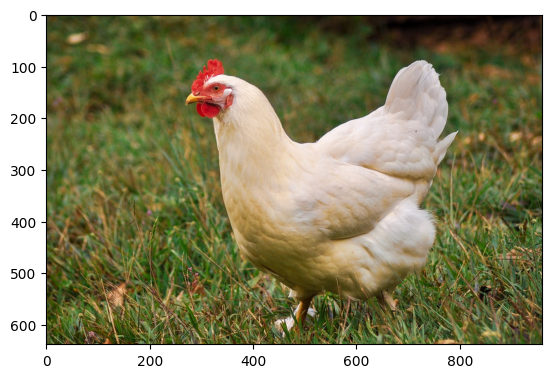

In [94]:
plt.imshow(test_img_data)

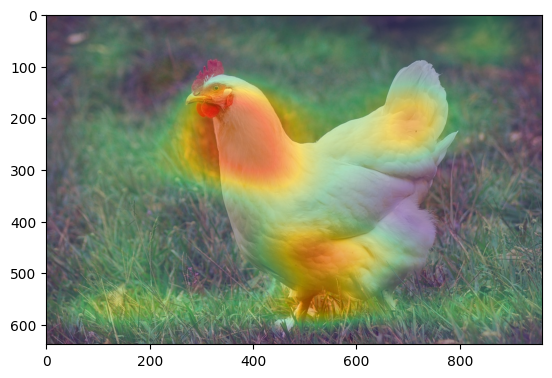

In [95]:
plt.imshow(output)